# VisionTransformer実践編
ViTについては、下記リンクで理論の解説を行った。今回はこのViTモデルを用いた画像分類を行う実践編である。  
http://document.tasdg.com.s3-website-ap-northeast-1.amazonaws.com/vision_transformer.html

今回の実践編で先の記事で解説を行った内容をすべて実装するのは時間がかかりすぎるので、すでに実装済み・事前学習済みのモデルを使用して画像分類を行ってみる。  
実装済み・事前学習済みのモデルは下記のGitHubリポジトリで公開されているので、それを使用する。  
https://github.com/faustomorales/vit-keras


その他、ViTを使った転移学習を行ったり、ViTをスマホにデプロイして使用する関連記事がいくつかあるので、参考までに記載しておく。   
https://qiita.com/T-STAR/items/728b5c279bcfb6a6381f  
https://qiita.com/SeeLog/items/786f0db58b66f35ce094


## 必要なライブラリのインストール


In [1]:
# !pip install vit-keras
# !pip install opencv-python

In [2]:
import pickle

import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vit_keras import vit, utils, visualize
from tensorflow.keras.mixed_precision import experimental as mixed_precision

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True


In [3]:
csv_path = './datasets/birds/birds.csv'
base_path = './datasets/birds/'

df = pd.read_csv(csv_path, index_col=0)

num_classes = len(set(df['labels'].tolist()))
label2id = {l: i for i, l in enumerate(set(df['labels'].tolist()))}
id2label = {v: k for k, v in label2id.items()}
pickle.dump(id2label, open('checkpoints/vit_model/id2label.pkl', 'wb'))

train_df = df[df['data set'] == 'train'].sample(frac=1)
valid_df = df[df['data set'] == 'test']

df.head()

,filepaths,labels,data set
0,train\AFRICAN CROWNED CRANE\001.jpg,AFRICAN CROWNED CRANE,train
1,train\AFRICAN CROWNED CRANE\002.jpg,AFRICAN CROWNED CRANE,train
2,train\AFRICAN CROWNED CRANE\003.jpg,AFRICAN CROWNED CRANE,train
3,train\AFRICAN CROWNED CRANE\004.jpg,AFRICAN CROWNED CRANE,train
4,train\AFRICAN CROWNED CRANE\005.jpg,AFRICAN CROWNED CRANE,train


In [4]:
img_size = 224
width, height = img_size, img_size

def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
    return image

def load_image_train(train_path, label):
    input_image = tf.io.read_file(train_path)
    input_image = tf.io.decode_image(input_image, channels=3, expand_animations=False)
    input_image = tf.image.resize(input_image, (width, height))
    input_image = data_augment(input_image)
    input_image /= 255
    return input_image, label

def load_image_valid(valid_path, label):
    input_image = tf.io.read_file(valid_path)
    input_image = tf.io.decode_image(input_image, channels=3, expand_animations=False)
    input_image = tf.image.resize(input_image, (width, height))
    input_image /= 255
    return input_image, label

train_image_path = [base_path+p.replace('\\', '/') for p in train_df['filepaths'].tolist()]
valid_image_path = [base_path+p.replace('\\', '/') for p in valid_df['filepaths'].tolist()]
train_labels = [label2id[l] for l in train_df['labels'].tolist()]
valid_labels = [label2id[l] for l in valid_df['labels'].tolist()]

train_image_path_ds = tf.data.Dataset.from_tensor_slices(train_image_path)
valid_image_path_ds = tf.data.Dataset.from_tensor_slices(valid_image_path)
train_labels_ds = tf.data.Dataset.from_tensor_slices(train_labels)
valid_labels_ds = tf.data.Dataset.from_tensor_slices(valid_labels)

train_ds = tf.data.Dataset.zip((train_image_path_ds, train_labels_ds))
valid_ds = tf.data.Dataset.zip((valid_image_path_ds, valid_labels_ds))

BATCH_SIZE = 8
STEPS_PER_EPOCH = int(len(train_image_path) / BATCH_SIZE)
train_ds = train_ds.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(load_image_valid, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


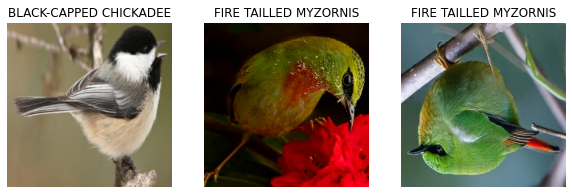

In [5]:
import random
import IPython.display as display

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(3)):
    ax = plt.subplot(1, 3, i+1)
    ax.set_title(id2label[int(label[0])])
    plt.imshow(image[0])
    plt.axis('off')

In [6]:
def create_model():
    vit_model = vit.vit_b16(
        image_size=img_size,
        activation='softmax',
        pretrained=True,
        include_top=True,
        pretrained_top=False,
        classes=num_classes
    )
    return vit_model

def decay(epoch):
    if epoch <= 10: return 1e-3
    elif epoch <= 13: return 1e-4
    else: return 1e-5

EPOCHS = 5
scheduler = tf.keras.callbacks.LearningRateScheduler(decay, verbose=1)
opt = tf.keras.optimizers.SGD(1e-3, momentum=0.9)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model = create_model()
model.compile(optimizer=opt, loss=loss,  metrics=['accuracy'])


C:\Users\mahoto\Anaconda3\envs\tensorflow\lib\site-packages\vit_keras\utils.py:77: UserWarning: Resizing position embeddings from 24 to 14
  warnings.warn(


In [7]:
history = model.fit(
          train_ds,
          epochs=EPOCHS,
          validation_data=valid_ds,
          verbose=1,
          callbacks=[scheduler]
        )

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
4815/4815 [==============================] - 3010s 621ms/step - loss: 1.8561 - accuracy: 0.6605 - val_loss: 0.0557 - val_accuracy: 0.9859
Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
4815/4815 [==============================] - 2970s 617ms/step - loss: 0.1462 - accuracy: 0.9636 - val_loss: 0.0392 - val_accuracy: 0.9896
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
4815/4815 [==============================] - 2951s 613ms/step - loss: 0.0961 - accuracy: 0.9742 - val_loss: 0.0328 - val_accuracy: 0.9911
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
4815/4815 [==============================] - 2952s 613ms/step - loss: 0.0667 - accuracy: 0.9830 - val_loss: 0.0255 - val_accuracy: 0.9919
Epoch 5/5

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
4815/4815 [==============================] - 2924s 60

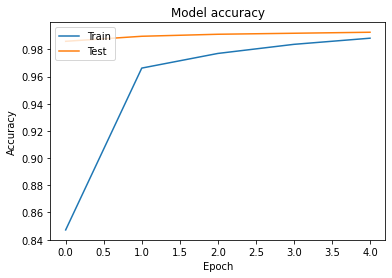

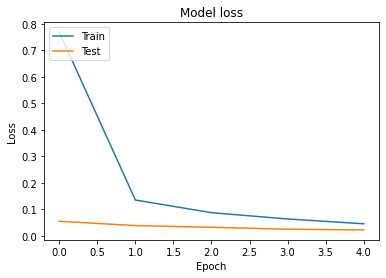

In [8]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

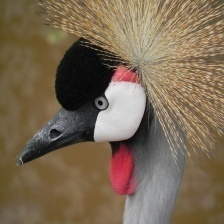

Predict Label is  AFRICAN CROWNED CRANE
Image Label is    AFRICAN CROWNED CRANE


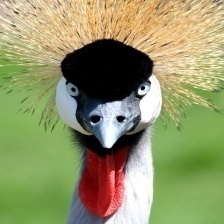

Predict Label is  AFRICAN CROWNED CRANE
Image Label is    AFRICAN CROWNED CRANE


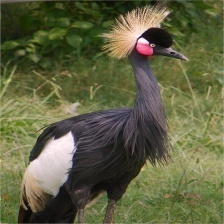

Predict Label is  AFRICAN CROWNED CRANE
Image Label is    AFRICAN CROWNED CRANE


In [9]:
from PIL import Image

for image_path in valid_df['filepaths'].tolist()[:3]:
    display.display(display.Image(base_path+image_path.replace('\\', '/')))
    im = Image.open(base_path+image_path.replace('\\', '/'))
    im = im.resize((img_size, img_size))
    im = np.array(im)
    im = im / 255
    im = np.expand_dims(im, 0)
    predict = model(im)
    print('Predict Label is ', id2label[np.argmax(predict, axis=1)[0]])
    print('Image Label is   ', image_path.split('\\')[1])

In [10]:
model.save_weights('./checkpoints/vit_model')
del model

model = create_model()
model.load_weights('./checkpoints/vit_model')

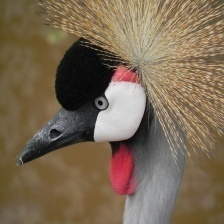

Predict Label is  AFRICAN CROWNED CRANE
Image Label is    AFRICAN CROWNED CRANE


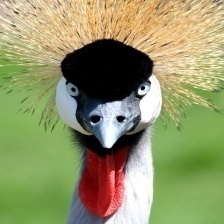

Predict Label is  AFRICAN CROWNED CRANE
Image Label is    AFRICAN CROWNED CRANE


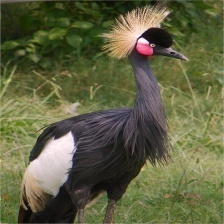

Predict Label is  AFRICAN CROWNED CRANE
Image Label is    AFRICAN CROWNED CRANE


In [11]:
for image_path in valid_df['filepaths'].tolist()[:3]:
    display.display(display.Image(base_path+image_path.replace('\\', '/')))
    im = Image.open(base_path+image_path.replace('\\', '/'))
    im = im.resize((img_size, img_size))
    im = np.array(im)
    im = im / 255
    im = np.expand_dims(im, 0)
    predict = model(im)
    print('Predict Label is ', id2label[np.argmax(predict, axis=1)[0]])
    print('Image Label is   ', image_path.split('\\')[1])